In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/학부연구생/

/content/drive/MyDrive/학부연구생


In [3]:
pip install torch numpy scipy scikit-learn matplotlib

In [4]:
from pathlib import Path
p = Path("/content/drive/MyDrive/학부연구생/data_multi.py")
src = p.read_text()

# 1) np.int -> np.int64
src = src.replace("dtype=np.int)", "dtype=np.int64)")

# 2) self.y.reshape((-1, 1)) -> self.y.to_numpy().reshape((-1, 1))
src = src.replace("self.y.reshape((-1, 1))", "self.y.to_numpy().reshape((-1, 1))")

p.write_text(src)
print("Patched data_multi.py")


Patched data_multi.py


In [5]:
%cd /content/drive/MyDrive/학부연구생
!python train.py --dataset mnist --size 15000 --lamdba 0.001 --nu 1 --hidden 100


/content/drive/MyDrive/학부연구생
0: 1.000, 1.726e-04, 1.188e+00, 1.146e+01, 1.137e+01
100: 77.000, 9.551e-04, 3.241e+00, 1.345e+01, 1.455e+01
200: 126.000, 1.703e-03, 4.067e+00, 1.297e+01, 1.441e+01
300: 169.000, 1.274e-03, 4.602e+00, 1.215e+01, 1.419e+01
400: 208.000, 1.580e-03, 3.931e+00, 8.307e+00, 9.363e+00
500: 242.000, 2.834e-03, 4.115e+00, 1.039e+01, 9.119e+00
600: 279.000, 3.731e-03, 5.455e+00, 1.551e+01, 1.515e+01
700: 311.000, 3.765e-03, 4.220e+00, 7.652e+00, 9.014e+00
800: 345.000, 3.907e-03, 5.978e+00, 9.319e+00, 8.706e+00
900: 376.000, 5.846e-03, 6.119e+00, 9.527e+00, 8.082e+00
1000: 407.000, 5.680e-03, 4.285e+00, 9.383e+00, 7.509e+00
1100: 433.000, 6.258e-03, 6.321e+00, 9.435e+00, 8.628e+00
1200: 464.000, 7.272e-03, 4.376e+00, 8.914e+00, 5.955e+00
1300: 486.000, 8.097e-03, 4.430e+00, 6.317e+00, 4.336e+00
1400: 513.000, 8.702e-03, 6.501e+00, 7.832e+00, 5.190e+00
1500: 538.000, 9.113e-03, 6.559e+00, 1.021e+01, 7.569e+00
1600: 554.000, 9.025e-03, 5.647e+00, 6.621e+00, 5.958e+00


In [6]:
!ls /content/drive/MyDrive/학부연구생/

data_multi.py					   __pycache__
learner_diag.py					   train.py
mnist__1.000e-03_1.000e+00_100_1755793123.7903428  Untitled0.ipynb


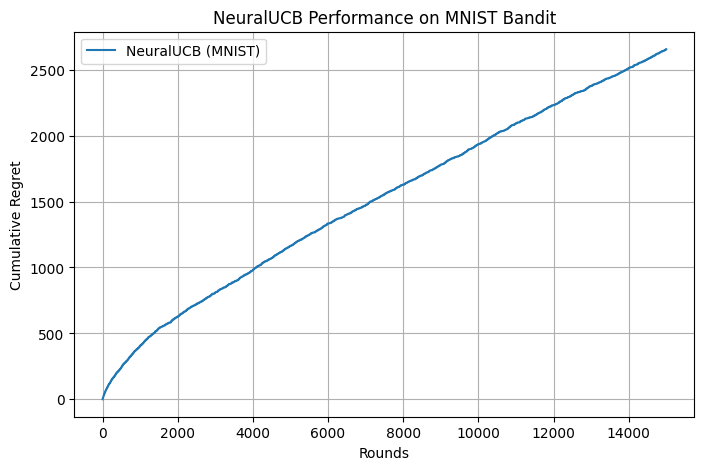

In [7]:
import matplotlib.pyplot as plt

# 결과 파일 경로
result_file = "/content/drive/MyDrive/학부연구생/mnist__1.000e-03_1.000e+00_100_1755793123.7903428"

# 데이터 불러오기
with open(result_file, "r") as f:
    regrets = [float(line.strip()) for line in f]

# 그래프 그리기
plt.figure(figsize=(8,5))
plt.plot(regrets, label="NeuralUCB (MNIST)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.title("NeuralUCB Performance on MNIST Bandit")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from data_multi import Bandit_multi

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE =", DEVICE)

# 간단한 MLP (learner_diag.Network와 동일 구조)
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))


DEVICE = cpu


#Random

In [4]:
def run_random(dataset='mnist', size=15000, seed=0):
    env = Bandit_multi(dataset, is_shuffle=True, seed=seed)
    regrets, summ = [], 0.0
    rng = np.random.default_rng(seed)
    for t in range(min(size, env.size)):
        X, rwd = env.step()
        a = rng.integers(0, env.n_arm)
        summ += (np.max(rwd) - rwd[a])
        regrets.append(summ)
    return np.array(regrets)



# LinUCB

In [5]:
class LinUCB:
    def __init__(self, dim, alpha=1.0, lam=1.0):
        self.alpha = alpha
        self.A = lam * np.eye(dim)
        self.A_inv = np.linalg.inv(self.A)
        self.b = np.zeros((dim,1))
    def select(self, X):  # X:(K,dim)
        theta = self.A_inv @ self.b
        mu = X @ theta                      # (K,1)
        s  = np.sqrt(np.einsum('ij,jk,ik->i', X, self.A_inv, X))
        return int(np.argmax(mu.ravel() + self.alpha * s))
    def update(self, x, r):
        x = x.reshape(-1,1)
        # Sherman–Morrison
        Ax = self.A_inv @ x
        denom = 1.0 + (x.T @ Ax)
        self.A_inv -= (Ax @ Ax.T) / denom
        self.b += r * x

def run_linucb(dataset='mnist', size=15000, alpha=1.0, lam=1.0, seed=0):
    env = Bandit_multi(dataset, is_shuffle=True, seed=seed)
    agent = LinUCB(env.dim, alpha=alpha, lam=lam)
    regrets, summ = [], 0.0
    for t in range(min(size, env.size)):
        X, rwd = env.step()
        a = agent.select(X)
        summ += float(np.max(rwd) - rwd[a])
        regrets.append(summ)
        agent.update(X[a], float(rwd[a]))
    return np.array(regrets)


# GLMUCB

In [6]:
class GLMUCB:
    def __init__(self, dim, alpha=1.0, lam=1.0, lr=0.5):
        self.alpha, self.lam, self.lr = alpha, lam, lr
        self.theta = np.zeros((dim,1))
        self.A = lam * np.eye(dim)
        self.A_inv = np.linalg.inv(self.A)
    @staticmethod
    def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))
    def select(self, X):
        mu = self.sigmoid(X @ self.theta).ravel()
        s  = np.sqrt(np.einsum('ij,jk,ik->i', X, self.A_inv, X))
        return int(np.argmax(mu + self.alpha*s))
    def update(self, x, r):
        x = x.reshape(-1,1)
        p = self.sigmoid(self.theta.T @ x)[0,0]
        grad = (p - r) * x + self.lam * self.theta
        self.theta -= self.lr * grad
        Ax = self.A_inv @ x
        self.A_inv -= (Ax @ Ax.T) / (1.0 + (x.T @ Ax))

def run_glmucb(dataset='mnist', size=15000, alpha=1.0, lam=1.0, lr=0.5, seed=0):
    env = Bandit_multi(dataset, is_shuffle=True, seed=seed)
    agent = GLMUCB(env.dim, alpha=alpha, lam=lam, lr=lr)
    regrets, summ = [], 0.0
    for t in range(min(size, env.size)):
        X, rwd = env.step()
        a = agent.select(X)
        summ += float(np.max(rwd) - rwd[a])
        regrets.append(summ)
        agent.update(X[a], float(rwd[a]))
    return np.array(regrets)



# Greedy NN

In [7]:
class GreedyNN:
    def __init__(self, dim, hidden=100, lam=1e-3, lr=1e-2):
        self.net = Network(dim, hidden_size=hidden).to(DEVICE)
        self.opt = optim.SGD(self.net.parameters(), lr=lr, weight_decay=lam)
        self.ctx, self.y = [], []
    @torch.no_grad()
    def predict(self, X):
        x = torch.from_numpy(X).float().to(DEVICE)
        return self.net(x).squeeze(-1).cpu().numpy()
    def update(self, x, r):
        self.ctx.append(torch.from_numpy(x.reshape(1,-1)).float())
        self.y.append(float(r))
        # 아주 가볍게 한 바퀴만
        idx = np.arange(len(self.y)); np.random.shuffle(idx)
        for i in idx[:32]:
            c = self.ctx[i].to(DEVICE)
            target = torch.tensor([[self.y[i]]], dtype=torch.float32, device=DEVICE)
            self.opt.zero_grad()
            loss = (self.net(c)-target).pow(2).mean()
            loss.backward(); self.opt.step()

def run_greedy_nn(dataset='mnist', size=15000, hidden=100, seed=0):
    env = Bandit_multi(dataset, is_shuffle=True, seed=seed)
    agent = GreedyNN(env.dim, hidden=hidden)
    regrets, summ = [], 0.0
    for t in range(min(size, env.size)):
        X, rwd = env.step()
        a = int(np.argmax(agent.predict(X)))
        summ += float(np.max(rwd) - rwd[a])
        regrets.append(summ)
        # train.py와 비슷한 가벼운 스케줄
        if t < 2000 or t % 200 == 0:
            agent.update(X[a], float(rwd[a]))
    return np.array(regrets)


In [10]:
import numpy as np
import time, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from data_multi import Bandit_multi

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

def _run_and_log(title, step_iter, T, log_every=50, save_path=None):
    regrets, summ = [], 0.0
    t0 = time.time()
    for t in range(T):
        reg = step_iter()
        summ += float(reg)
        regrets.append(summ)
        if (t+1) % log_every == 0 or (t+1) == T:
            dt = time.time() - t0
            print(f"[{title}] t={t+1}/{T} | avg {dt/log_every:.4f}s/round | cum_reg={summ:.3f}")
            t0 = time.time()
    if save_path:
        np.savetxt(save_path, regrets)
        print(f"[Saved] {save_path}")
    plt.figure(figsize=(7,4))
    plt.plot(regrets); plt.xlabel("Round"); plt.ylabel("Cumulative Regret")
    plt.title(title); plt.grid(True); plt.show()
    return np.array(regrets)

# --- Random (env 재사용) ---
def run_random_env(env, T=100, seed=0, log_every=50, save_path=None):
    env.reset()
    rng = np.random.default_rng(seed)
    def step_iter():
        X, rwd = env.step()
        a = rng.integers(0, env.n_arm)
        return np.max(rwd) - rwd[a]
    return _run_and_log(f"Random – {T}", step_iter, min(T, env.size), log_every, save_path)

# --- LinUCB (env 재사용) ---
class LinUCB:
    def __init__(self, dim, alpha=1.0, lam=1.0):
        self.alpha = alpha
        self.A = lam * np.eye(dim); self.A_inv = np.linalg.inv(self.A)
        self.b = np.zeros((dim,1))
    def select(self, X):
        theta = self.A_inv @ self.b
        mu = X @ theta
        s = np.sqrt(np.einsum('ij,jk,ik->i', X, self.A_inv, X))
        return int(np.argmax(mu.ravel() + self.alpha*s))
    def update(self, x, r):
        x = x.reshape(-1,1)
        Ax = self.A_inv @ x
        self.A_inv -= (Ax @ Ax.T) / (1.0 + (x.T @ Ax))
        self.b += r * x

def run_linucb_env(env, T=100, alpha=1.0, lam=1.0, log_every=50, save_path=None):
    env.reset()
    agent = LinUCB(env.dim, alpha=alpha, lam=lam)
    def step_iter():
        X, rwd = env.step()
        a = agent.select(X)
        agent.update(X[a], float(rwd[a]))
        return np.max(rwd) - rwd[a]
    return _run_and_log(f"LinUCB – {T}", step_iter, min(T, env.size), log_every, save_path)

# --- GLMUCB (env 재사용) ---
class GLMUCB:
    def __init__(self, dim, alpha=1.0, lam=1.0, lr=0.5):
        self.alpha, self.lam, self.lr = alpha, lam, lr
        self.theta = np.zeros((dim,1))
        self.A = lam * np.eye(dim); self.A_inv = np.linalg.inv(self.A)
    @staticmethod
    def sigmoid(z): return 1.0/(1.0+np.exp(-z))
    def select(self, X):
        mu = self.sigmoid(X @ self.theta).ravel()
        s  = np.sqrt(np.einsum('ij,jk,ik->i', X, self.A_inv, X))
        return int(np.argmax(mu + self.alpha*s))
    def update(self, x, r):
        x = x.reshape(-1,1)
        p = self.sigmoid(self.theta.T @ x)[0,0]
        grad = (p - r) * x + self.lam * self.theta
        self.theta -= self.lr * grad
        Ax = self.A_inv @ x
        self.A_inv -= (Ax @ Ax.T) / (1.0 + (x.T @ Ax))

def run_glmucb_env(env, T=100, alpha=1.0, lam=1.0, lr=0.5, log_every=50, save_path=None):
    env.reset()
    agent = GLMUCB(env.dim, alpha=alpha, lam=lam, lr=lr)
    def step_iter():
        X, rwd = env.step()
        a = agent.select(X)
        agent.update(X[a], float(rwd[a]))
        return np.max(rwd) - rwd[a]
    return _run_and_log(f"GLMUCB – {T}", step_iter, min(T, env.size), log_every, save_path)

# --- Greedy NN (env 재사용) ---
class GreedyNN:
    def __init__(self, dim, hidden=100, lam=1e-3, lr=1e-2):
        self.net = Network(dim, hidden_size=hidden).to(DEVICE)
        self.opt = optim.SGD(self.net.parameters(), lr=lr, weight_decay=lam)
        self.ctx, self.y = [], []
    @torch.no_grad()
    def predict(self, X):
        x = torch.from_numpy(X).float().to(DEVICE)
        return self.net(x).squeeze(-1).cpu().numpy()
    def update(self, x, r):
        self.ctx.append(torch.from_numpy(x.reshape(1,-1)).float())
        self.y.append(float(r))
        idx = np.arange(len(self.y)); np.random.shuffle(idx)
        for i in idx[:16]:  # 아주 가볍게
            c = self.ctx[i].to(DEVICE)
            target = torch.tensor([[self.y[i]]], dtype=torch.float32, device=DEVICE)
            self.opt.zero_grad()
            loss = (self.net(c)-target).pow(2).mean()
            loss.backward(); self.opt.step()

def run_greedy_nn_env(env, T=100, hidden=100, lam=1e-3, lr=1e-2, log_every=50, save_path=None):
    env.reset()
    agent = GreedyNN(env.dim, hidden=hidden, lam=lam, lr=lr)
    def step_iter():
        X, rwd = env.step()
        a = int(np.argmax(agent.predict(X)))
        if env.cursor < 2000 or env.cursor % 200 == 0:
            agent.update(X[a], float(rwd[a]))
        return np.max(rwd) - rwd[a]
    return _run_and_log(f"GreedyNN – {T}", step_iter, min(T, env.size), log_every, save_path)


[Random – 100] t=25/100 | avg 0.0000s/round | cum_reg=22.000
[Random – 100] t=50/100 | avg 0.0000s/round | cum_reg=42.000
[Random – 100] t=75/100 | avg 0.0000s/round | cum_reg=66.000
[Random – 100] t=100/100 | avg 0.0000s/round | cum_reg=88.000
[Saved] /content/drive/MyDrive/학부연구생/mnist__Random_100.txt


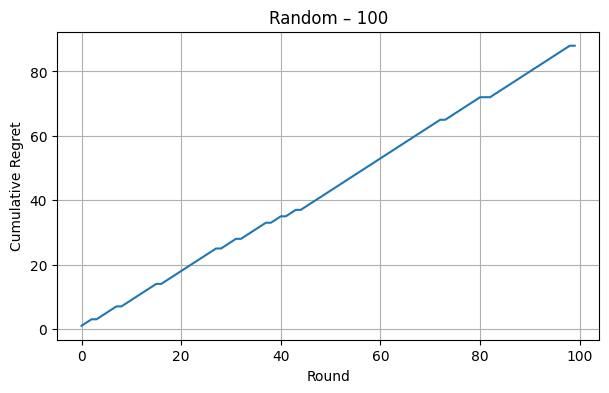

[LinUCB – 100] t=25/100 | avg 1.2724s/round | cum_reg=20.000
[LinUCB – 100] t=50/100 | avg 1.2738s/round | cum_reg=38.000
[LinUCB – 100] t=75/100 | avg 1.2708s/round | cum_reg=52.000
[LinUCB – 100] t=100/100 | avg 1.2704s/round | cum_reg=65.000
[Saved] /content/drive/MyDrive/학부연구생/mnist__LinUCB_100.txt


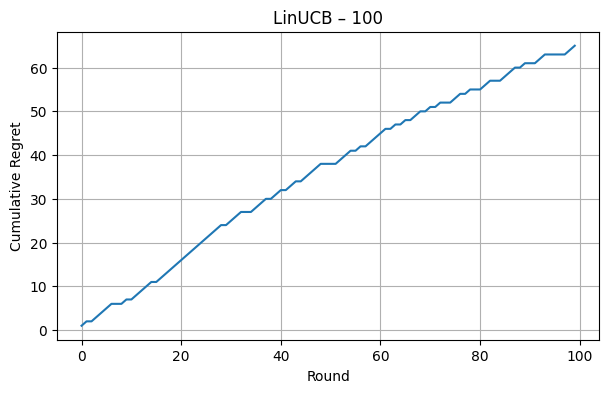

[GLMUCB – 100] t=25/100 | avg 1.2474s/round | cum_reg=22.000
[GLMUCB – 100] t=50/100 | avg 1.2478s/round | cum_reg=46.000
[GLMUCB – 100] t=75/100 | avg 1.2472s/round | cum_reg=70.000
[GLMUCB – 100] t=100/100 | avg 1.2516s/round | cum_reg=87.000
[Saved] /content/drive/MyDrive/학부연구생/mnist__GLMUCB_100.txt


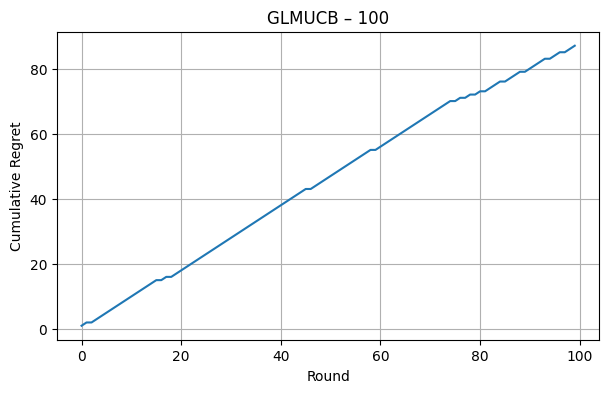

[GreedyNN – 100] t=25/100 | avg 0.0172s/round | cum_reg=22.000
[GreedyNN – 100] t=50/100 | avg 0.0248s/round | cum_reg=41.000
[GreedyNN – 100] t=75/100 | avg 0.0258s/round | cum_reg=59.000
[GreedyNN – 100] t=100/100 | avg 0.0265s/round | cum_reg=77.000
[Saved] /content/drive/MyDrive/학부연구생/mnist__GreedyNN_100.txt


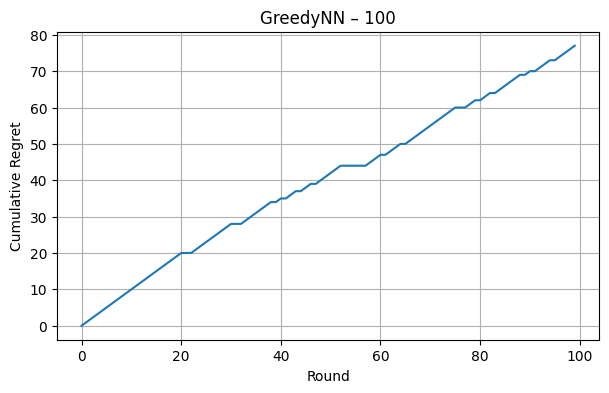

In [11]:
# 1) 환경 한 번만 로딩 (여기서 OpenML 다운로드가 처음 1~2분 걸릴 수 있음)
env = Bandit_multi("mnist", is_shuffle=True, seed=0)

# 2) 각 알고리즘을 "따로따로" 실행 (env 재사용 + 중간 진행 출력)
_ = run_random_env(env, T=100, log_every=25, save_path="/content/drive/MyDrive/학부연구생/mnist__Random_100.txt")
_ = run_linucb_env(env, T=100, alpha=1.0, lam=1.0, log_every=25, save_path="/content/drive/MyDrive/학부연구생/mnist__LinUCB_100.txt")
_ = run_glmucb_env(env, T=100, alpha=1.0, lam=1.0, lr=0.5, log_every=25, save_path="/content/drive/MyDrive/학부연구생/mnist__GLMUCB_100.txt")
_ = run_greedy_nn_env(env, T=100, hidden=100, log_every=25, save_path="/content/drive/MyDrive/학부연구생/mnist__GreedyNN_100.txt")


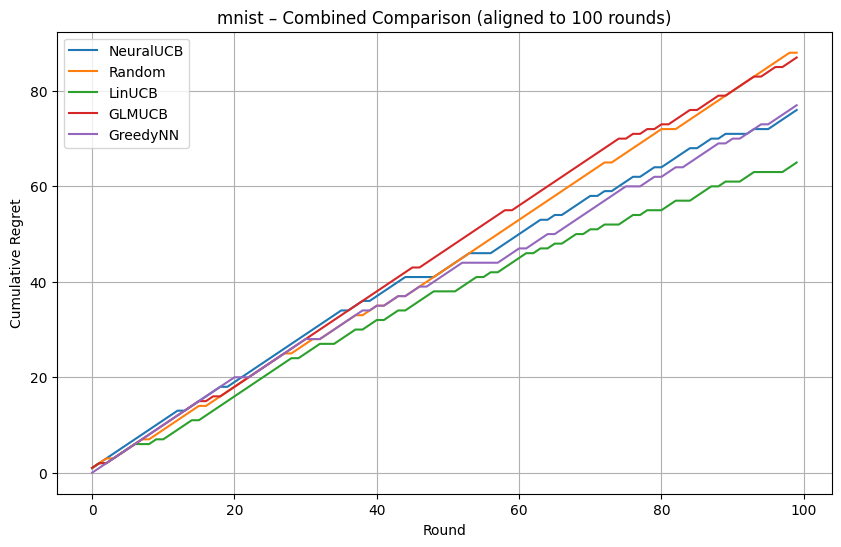

▶ 포함된 파일:
 - NeuralUCB   : mnist__1.000e-03_1.000e+00_100_1755793123.7903428 (len=15000)
 - Random      : mnist__Random_100.txt (len=100)
 - LinUCB      : mnist__LinUCB_100.txt (len=100)
 - GLMUCB      : mnist__GLMUCB_100.txt (len=100)
 - GreedyNN    : mnist__GreedyNN_100.txt (len=100)


In [12]:
# ✅ 한 그래프에 전부 모아 그리기
import os, glob
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/학부연구생"
DATASET = "mnist"   # <-- 필요하면 'covertype', 'magic', 'statlog' 등으로 변경

def latest_neuralucb_file(ds):
    cand = [f for f in glob.glob(f"{BASE_DIR}/{ds}__*")
            if all(key not in f for key in ["Random", "LinUCB", "GLMUCB", "GreedyNN"])]
    return sorted(cand)[-1] if cand else None

series = []

# NeuralUCB
neu_file = latest_neuralucb_file(DATASET)
if neu_file:
    series.append(("NeuralUCB", np.loadtxt(neu_file), os.path.basename(neu_file)))

# Baselines
for name in ["Random", "LinUCB", "GLMUCB", "GreedyNN"]:
    files = sorted(glob.glob(f"{BASE_DIR}/{DATASET}__{name}_*.txt"))
    if files:
        series.append((name, np.loadtxt(files[-1]), os.path.basename(files[-1])))

if not series:
    print("결과 파일을 찾지 못했습니다. 먼저 각 알고리즘을 실행해 결과 파일을 생성하세요.")
else:
    min_len = min(len(arr) for _, arr, _ in series)
    plt.figure(figsize=(10,6))
    for label, arr, fname in series:
        plt.plot(arr[:min_len], label=label)
    plt.xlabel("Round"); plt.ylabel("Cumulative Regret")
    plt.title(f"{DATASET} – Combined Comparison (aligned to {min_len} rounds)")
    plt.grid(True); plt.legend()
    plt.show()

    print("▶ 포함된 파일:")
    for label, arr, fname in series:
        print(f" - {label:12s}: {fname} (len={len(arr)})")


In [13]:
import numpy as np
import time, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from data_multi import Bandit_multi

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

def _run_and_log(title, step_iter, T, log_every=50, save_path=None):
    regrets, summ = [], 0.0
    t0 = time.time()
    for t in range(T):
        reg = step_iter()
        summ += float(reg)
        regrets.append(summ)
        if (t+1) % log_every == 0 or (t+1) == T:
            dt = time.time() - t0
            print(f"[{title}] t={t+1}/{T} | avg {dt/log_every:.4f}s/round | cum_reg={summ:.3f}")
            t0 = time.time()
    if save_path:
        np.savetxt(save_path, regrets)
        print(f"[Saved] {save_path}")
    plt.figure(figsize=(7,4))
    plt.plot(regrets); plt.xlabel("Round"); plt.ylabel("Cumulative Regret")
    plt.title(title); plt.grid(True); plt.show()
    return np.array(regrets)

# --- Random ---
def run_random_env(env, T=1000, seed=0, log_every=50, save_path=None):
    env.reset()
    rng = np.random.default_rng(seed)
    def step_iter():
        X, rwd = env.step()
        a = rng.integers(0, env.n_arm)
        return np.max(rwd) - rwd[a]
    return _run_and_log(f"Random – {T}", step_iter, min(T, env.size), log_every, save_path)

# --- LinUCB ---
class LinUCB:
    def __init__(self, dim, alpha=1.0, lam=1.0):
        self.alpha = alpha
        self.A = lam * np.eye(dim); self.A_inv = np.linalg.inv(self.A)
        self.b = np.zeros((dim,1))
    def select(self, X):
        theta = self.A_inv @ self.b
        mu = X @ theta
        s = np.sqrt(np.einsum('ij,jk,ik->i', X, self.A_inv, X))
        return int(np.argmax(mu.ravel() + self.alpha*s))
    def update(self, x, r):
        x = x.reshape(-1,1)
        Ax = self.A_inv @ x
        self.A_inv -= (Ax @ Ax.T) / (1.0 + (x.T @ Ax))
        self.b += r * x

def run_linucb_env(env, T=1000, alpha=1.0, lam=1.0, log_every=50, save_path=None):
    env.reset()
    agent = LinUCB(env.dim, alpha=alpha, lam=lam)
    def step_iter():
        X, rwd = env.step()
        a = agent.select(X)
        agent.update(X[a], float(rwd[a]))
        return np.max(rwd) - rwd[a]
    return _run_and_log(f"LinUCB – {T}", step_iter, min(T, env.size), log_every, save_path)

# --- GLMUCB ---
class GLMUCB:
    def __init__(self, dim, alpha=1.0, lam=1.0, lr=0.5):
        self.alpha, self.lam, self.lr = alpha, lam, lr
        self.theta = np.zeros((dim,1))
        self.A = lam * np.eye(dim); self.A_inv = np.linalg.inv(self.A)
    @staticmethod
    def sigmoid(z): return 1.0/(1.0+np.exp(-z))
    def select(self, X):
        mu = self.sigmoid(X @ self.theta).ravel()
        s  = np.sqrt(np.einsum('ij,jk,ik->i', X, self.A_inv, X))
        return int(np.argmax(mu + self.alpha*s))
    def update(self, x, r):
        x = x.reshape(-1,1)
        p = self.sigmoid(self.theta.T @ x)[0,0]
        grad = (p - r) * x + self.lam * self.theta
        self.theta -= self.lr * grad
        Ax = self.A_inv @ x
        self.A_inv -= (Ax @ Ax.T) / (1.0 + (x.T @ Ax))

def run_glmucb_env(env, T=1000, alpha=1.0, lam=1.0, lr=0.5, log_every=50, save_path=None):
    env.reset()
    agent = GLMUCB(env.dim, alpha=alpha, lam=lam, lr=lr)
    def step_iter():
        X, rwd = env.step()
        a = agent.select(X)
        agent.update(X[a], float(rwd[a]))
        return np.max(rwd) - rwd[a]
    return _run_and_log(f"GLMUCB – {T}", step_iter, min(T, env.size), log_every, save_path)

# --- Greedy NN ---
class GreedyNN:
    def __init__(self, dim, hidden=100, lam=1e-3, lr=1e-2):
        self.net = Network(dim, hidden_size=hidden).to(DEVICE)
        self.opt = optim.SGD(self.net.parameters(), lr=lr, weight_decay=lam)
        self.ctx, self.y = [], []
    @torch.no_grad()
    def predict(self, X):
        x = torch.from_numpy(X).float().to(DEVICE)
        return self.net(x).squeeze(-1).cpu().numpy()
    def update(self, x, r):
        self.ctx.append(torch.from_numpy(x.reshape(1,-1)).float())
        self.y.append(float(r))
        idx = np.arange(len(self.y)); np.random.shuffle(idx)
        for i in idx[:16]:
            c = self.ctx[i].to(DEVICE)
            target = torch.tensor([[self.y[i]]], dtype=torch.float32, device=DEVICE)
            self.opt.zero_grad()
            loss = (self.net(c)-target).pow(2).mean()
            loss.backward(); self.opt.step()

def run_greedy_nn_env(env, T=1000, hidden=100, lam=1e-3, lr=1e-2, log_every=50, save_path=None):
    env.reset()
    agent = GreedyNN(env.dim, hidden=hidden, lam=lam, lr=lr)
    def step_iter():
        X, rwd = env.step()
        a = int(np.argmax(agent.predict(X)))
        if env.cursor < 2000 or env.cursor % 200 == 0:
            agent.update(X[a], float(rwd[a]))
        return np.max(rwd) - rwd[a]
    return _run_and_log(f"GreedyNN – {T}", step_iter, min(T, env.size), log_every, save_path)

[Random – 10000] t=500/10000 | avg 0.0000s/round | cum_reg=442.000
[Random – 10000] t=1000/10000 | avg 0.0000s/round | cum_reg=892.000
[Random – 10000] t=1500/10000 | avg 0.0000s/round | cum_reg=1333.000
[Random – 10000] t=2000/10000 | avg 0.0000s/round | cum_reg=1781.000
[Random – 10000] t=2500/10000 | avg 0.0000s/round | cum_reg=2222.000
[Random – 10000] t=3000/10000 | avg 0.0000s/round | cum_reg=2667.000
[Random – 10000] t=3500/10000 | avg 0.0000s/round | cum_reg=3117.000
[Random – 10000] t=4000/10000 | avg 0.0000s/round | cum_reg=3565.000
[Random – 10000] t=4500/10000 | avg 0.0000s/round | cum_reg=4018.000
[Random – 10000] t=5000/10000 | avg 0.0000s/round | cum_reg=4473.000
[Random – 10000] t=5500/10000 | avg 0.0000s/round | cum_reg=4931.000
[Random – 10000] t=6000/10000 | avg 0.0000s/round | cum_reg=5374.000
[Random – 10000] t=6500/10000 | avg 0.0000s/round | cum_reg=5828.000
[Random – 10000] t=7000/10000 | avg 0.0000s/round | cum_reg=6275.000
[Random – 10000] t=7500/10000 | avg 0

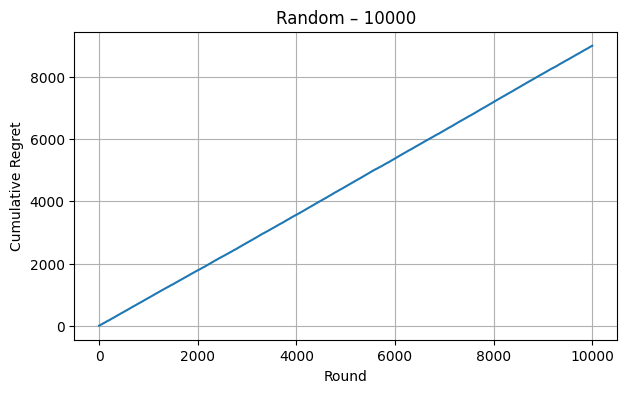

[LinUCB – 10000] t=500/10000 | avg 1.2643s/round | cum_reg=218.000
[LinUCB – 10000] t=1000/10000 | avg 1.2664s/round | cum_reg=343.000
[LinUCB – 10000] t=1500/10000 | avg 1.2635s/round | cum_reg=433.000
[LinUCB – 10000] t=2000/10000 | avg 1.2635s/round | cum_reg=509.000
[LinUCB – 10000] t=2500/10000 | avg 1.2638s/round | cum_reg=588.000
[LinUCB – 10000] t=3000/10000 | avg 1.2641s/round | cum_reg=682.000
[LinUCB – 10000] t=3500/10000 | avg 1.2631s/round | cum_reg=759.000
[LinUCB – 10000] t=4000/10000 | avg 1.2645s/round | cum_reg=830.000
[LinUCB – 10000] t=4500/10000 | avg 1.2636s/round | cum_reg=910.000
[LinUCB – 10000] t=5000/10000 | avg 1.2647s/round | cum_reg=992.000
[LinUCB – 10000] t=5500/10000 | avg 1.2647s/round | cum_reg=1051.000
[LinUCB – 10000] t=6000/10000 | avg 1.2635s/round | cum_reg=1125.000
[LinUCB – 10000] t=6500/10000 | avg 1.2644s/round | cum_reg=1194.000
[LinUCB – 10000] t=7000/10000 | avg 1.2642s/round | cum_reg=1252.000
[LinUCB – 10000] t=7500/10000 | avg 1.2639s/r

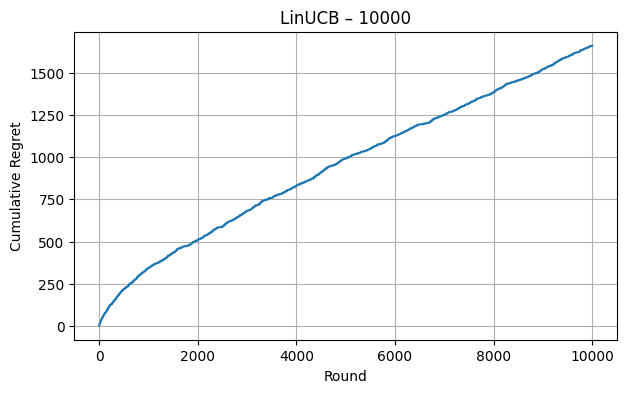

[GLMUCB – 10000] t=500/10000 | avg 1.2510s/round | cum_reg=444.000
[GLMUCB – 10000] t=1000/10000 | avg 1.2512s/round | cum_reg=904.000
[GLMUCB – 10000] t=1500/10000 | avg 1.2512s/round | cum_reg=1346.000
[GLMUCB – 10000] t=2000/10000 | avg 1.2516s/round | cum_reg=1804.000
[GLMUCB – 10000] t=2500/10000 | avg 1.2516s/round | cum_reg=2245.000
[GLMUCB – 10000] t=3000/10000 | avg 1.2512s/round | cum_reg=2693.000
[GLMUCB – 10000] t=3500/10000 | avg 1.2515s/round | cum_reg=3133.000
[GLMUCB – 10000] t=4000/10000 | avg 1.2511s/round | cum_reg=3592.000
[GLMUCB – 10000] t=4500/10000 | avg 1.2515s/round | cum_reg=4053.000
[GLMUCB – 10000] t=5000/10000 | avg 1.2518s/round | cum_reg=4497.000
[GLMUCB – 10000] t=5500/10000 | avg 1.2508s/round | cum_reg=4950.000
[GLMUCB – 10000] t=6000/10000 | avg 1.2510s/round | cum_reg=5396.000
[GLMUCB – 10000] t=6500/10000 | avg 1.2517s/round | cum_reg=5847.000
[GLMUCB – 10000] t=7000/10000 | avg 1.2515s/round | cum_reg=6290.000
[GLMUCB – 10000] t=7500/10000 | avg 1

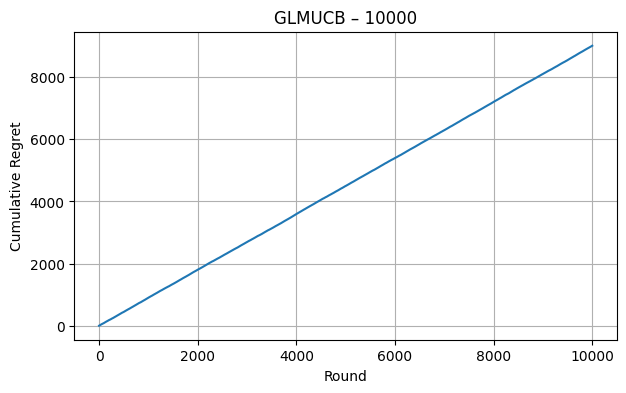

[GreedyNN – 10000] t=500/10000 | avg 0.0277s/round | cum_reg=400.000
[GreedyNN – 10000] t=1000/10000 | avg 0.0295s/round | cum_reg=731.000
[GreedyNN – 10000] t=1500/10000 | avg 0.0296s/round | cum_reg=952.000
[GreedyNN – 10000] t=2000/10000 | avg 0.0296s/round | cum_reg=1147.000
[GreedyNN – 10000] t=2500/10000 | avg 0.0005s/round | cum_reg=1331.000
[GreedyNN – 10000] t=3000/10000 | avg 0.0005s/round | cum_reg=1514.000
[GreedyNN – 10000] t=3500/10000 | avg 0.0005s/round | cum_reg=1681.000
[GreedyNN – 10000] t=4000/10000 | avg 0.0005s/round | cum_reg=1877.000
[GreedyNN – 10000] t=4500/10000 | avg 0.0005s/round | cum_reg=2054.000
[GreedyNN – 10000] t=5000/10000 | avg 0.0005s/round | cum_reg=2237.000
[GreedyNN – 10000] t=5500/10000 | avg 0.0005s/round | cum_reg=2388.000
[GreedyNN – 10000] t=6000/10000 | avg 0.0005s/round | cum_reg=2567.000
[GreedyNN – 10000] t=6500/10000 | avg 0.0005s/round | cum_reg=2715.000
[GreedyNN – 10000] t=7000/10000 | avg 0.0005s/round | cum_reg=2890.000
[GreedyNN 

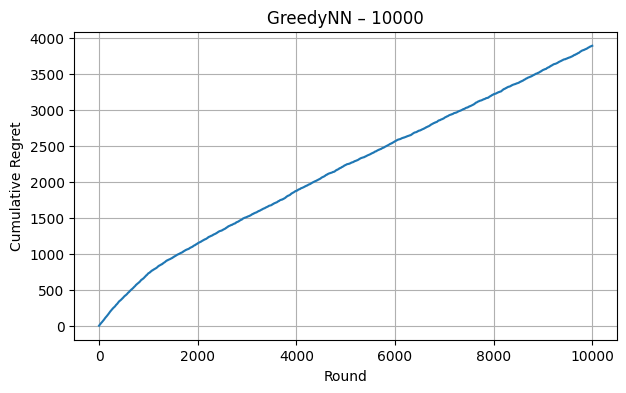

In [15]:
# =============================
# 실행부 (T=10000으로 변경)
# =============================
env = Bandit_multi("mnist", is_shuffle=True, seed=0)

_ = run_random_env(env, T=10000, log_every=500,
                   save_path="/content/drive/MyDrive/학부연구생/mnist__Random_10000.txt")

_ = run_linucb_env(env, T=10000, alpha=1.0, lam=1.0, log_every=500,
                   save_path="/content/drive/MyDrive/학부연구생/mnist__LinUCB_10000.txt")

_ = run_glmucb_env(env, T=10000, alpha=1.0, lam=1.0, lr=0.5, log_every=500,
                   save_path="/content/drive/MyDrive/학부연구생/mnist__GLMUCB_10000.txt")

_ = run_greedy_nn_env(env, T=10000, hidden=100, log_every=500,
                      save_path="/content/drive/MyDrive/학부연구생/mnist__GreedyNN_10000.txt")


# 📈 NeuralUCB + (Random/LinUCB/GLMUCB/GreedyNN) 비교 그래프

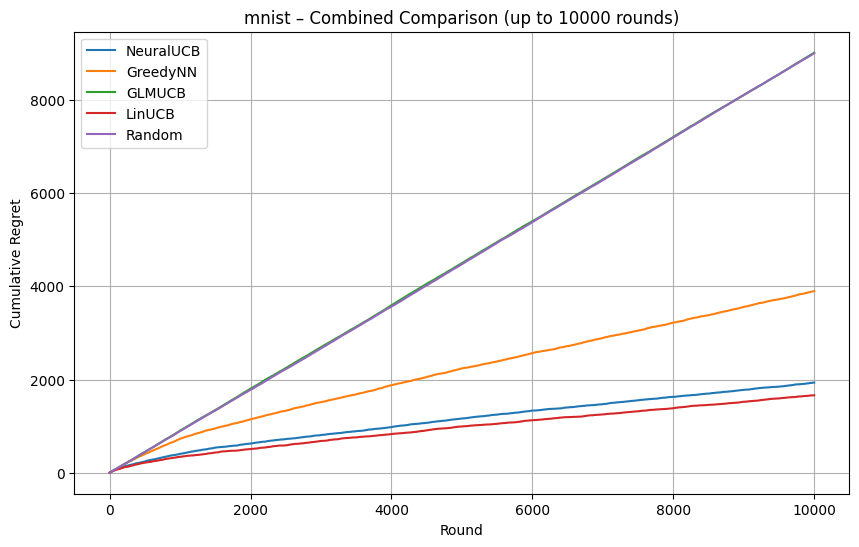

▶ 포함된 파일:
 - NeuralUCB : mnist__1.000e-03_1.000e+00_100_1755793123.7903428 (len=15000)
 - GreedyNN  : mnist__GreedyNN_10000.txt (len=10000)
 - GLMUCB    : mnist__GLMUCB_10000.txt (len=10000)
 - LinUCB    : mnist__LinUCB_10000.txt (len=10000)
 - Random    : mnist__Random_10000.txt (len=10000)


In [16]:

import os, glob
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR  = "/content/drive/MyDrive/학부연구생"
DATASET   = "mnist"
TARGET_T  = 10000
SMOOTH_W  = 0

def latest_neuralucb_file(ds):

    cand = [f for f in glob.glob(f"{BASE_DIR}/{ds}__*")
            if all(k not in os.path.basename(f) for k in ["Random","LinUCB","GLMUCB","GreedyNN"])]
    return sorted(cand)[-1] if cand else None

def load_latest(ds, name_pattern):
    files = sorted(glob.glob(f"{BASE_DIR}/{ds}__{name_pattern}"))
    return files[-1] if files else None

def moving_average(x, w):
    if w <= 1: return x
    if w % 2 == 0: w += 1
    pad = w // 2
    xpad = np.pad(x, (pad, pad), mode='edge')
    kernel = np.ones(w)/w
    return np.convolve(xpad, kernel, mode='valid')

series = []  # (label, np.array, filename)

# 1) NeuralUCB
neu_file = latest_neuralucb_file(DATASET)
if neu_file:
    series.append(("NeuralUCB", np.loadtxt(neu_file), os.path.basename(neu_file)))

# 2) Baselines
for label, pat in [
    ("Random",   "Random_*.txt"),
    ("LinUCB",   "LinUCB_*.txt"),
    ("GLMUCB",   "GLMUCB_*.txt"),
    ("GreedyNN", "GreedyNN_*.txt"),
]:
    f = load_latest(DATASET, pat)
    if f:
        series.append((label, np.loadtxt(f), os.path.basename(f)))

if not series:
    print("❌ 결과 파일을 찾지 못했습니다. 일부 알고리즘을 먼저 실행해 파일을 생성하세요.")
else:

    order = {"NeuralUCB":0, "GreedyNN":1, "GLMUCB":2, "LinUCB":3, "Random":4}
    series.sort(key=lambda x: order.get(x[0], 99))

    # 길이 정렬 (TARGET_T와 공통 가능한 최소 길이)
    min_len = min(min(len(arr), TARGET_T) for _, arr, _ in series)
    plt.figure(figsize=(10,6))
    for label, arr, fname in series:
        y = arr[:min_len]
        if SMOOTH_W > 1:
            y = moving_average(y, SMOOTH_W)
        plt.plot(y, label=label)
    plt.xlabel("Round"); plt.ylabel("Cumulative Regret")
    plt.title(f"{DATASET} – Combined Comparison (up to {min_len} rounds)")
    plt.grid(True); plt.legend()
    plt.show()

    print("▶ 포함된 파일:")
    for label, arr, fname in series:
        print(f" - {label:10s}: {fname} (len={len(arr)})")


## 논문에서의 결론 (이론 + 실험)

NeuralUCB는

DNN 표현력을 활용해 보상 함수의 비선형성을 잘 학습

UCB 기반 탐색으로 효율적인 exploration

결과적으로 Õ(dₑ√T) 후회 보장 (linear bandit의 후회를 일반화)

실험에서도 LinUCB, GLMUCB, KernelUCB 대비 후회가 더 낮게 나옴.

BootstrappedNN은 비슷한 성능을 보이지만 계산량이 크고,

NeuralUCB0(단순화 버전)는 NeuralUCB보다 약간 성능이 떨어짐.

최종 결론 → NeuralUCB가 비선형 보상 함수 환경에서 가장 안정적이고 효율적.

# 내가 실험한 결과

LinUCB: 가장 낮은 후회 (우리가 얻은 결과에서는 NeuralUCB보다 더 잘함)

NeuralUCB: LinUCB보다는 살짝 높은 후회

GreedyNN: NeuralUCB보다는 안 좋지만, Random보다는 훨씬 나음

GLMUCB, Random: 후회가 가장 큼, 탐색이 제대로 안 되는 한계가 드러남

## 차이가 발생한 이유
- 데이터 변환 방식

  Bandit_multi는 MNIST를 one-hot 기반 bandit 문제로 바꿨는데, 이 구조에서는 오히려 선형 모델(LinUCB) 이 잘 맞아떨어질 수 있음.즉, 원래 논문에서 고려한 "일반적 비선형 보상 함수" 환경과 다를 수도 있을 것 같다.

- 실험 세팅 차이

  논문은 T=15000 이상, 파라미터 튜닝(λ, ν, hidden size 등)을 해서 NeuralUCB의 장점을 끌어냈음. 지금은 기본 파라미터, 10000 라운드 → NeuralUCB가 충분히 학습하지 못했을 수 있고 나머지 모델의 세팅도 정확하게 나와있지 않아서 결과가 달라졌을 수 있을듯.

- 구현 및 학습 스케줄

  NeuralUCB의 이론적 분석은 Neural Tangent Kernel 기반이지만, 실제 구현은 근사치. 업데이트 주기, 학습률, 정규화 λ 값에 따라 NeuralUCB 성능이 크게 달라짐.